#### Image Classification and Segmentation with Tensorflow and TF-Slim
http://warmspringwinds.github.io/tensorflow/tf-slim/2016/10/30/image-classification-and-segmentation-using-tensorflow-and-tf-slim/

In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append('/home/cdathuraliya/work/lirneasia/git/models/slim/')

In [3]:
from datasets import dataset_utils
import tensorflow as tf

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"

# Specify where you want to download the model to
checkpoints_dir = '/home/cdathuraliya/work/misc/tensorflow/slim-segmentation/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading vgg_16_2016_08_28.tar.gz 100.0%
Successfully downloaded vgg_16_2016_08_28.tar.gz 513324920 bytes.


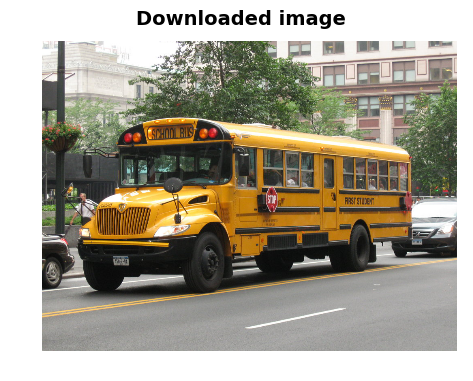

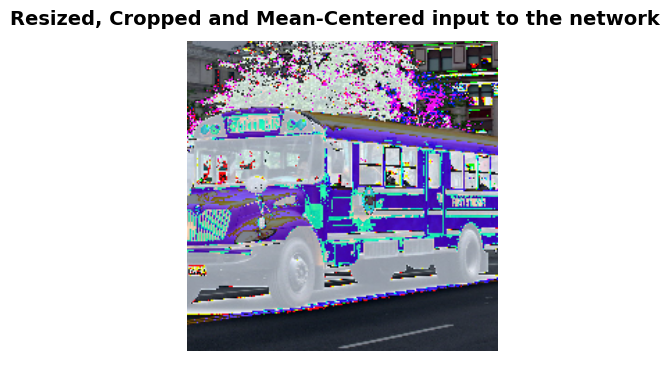

Probability 1.00 => [school bus]
Probability 0.00 => [minibus]
Probability 0.00 => [passenger car, coach, carriage]
Probability 0.00 => [trolleybus, trolley coach, trackless trolley]
Probability 0.00 => [cab, hack, taxi, taxicab]


In [4]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

checkpoints_dir = '/home/cdathuraliya/work/misc/tensorflow/slim-segmentation/checkpoints'

slim = tf.contrib.slim

# We need default size of image for a particular network.
# The network was trained on images of that size -- so we
# resize input image later in the code.
image_size = vgg.vgg_16.default_image_size


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    # Open specified url and load image as a string
    image_string = urllib2.urlopen(url).read()
    
    # Decode string into matrix with intensity values
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Resize the input image, preserving the aspect ratio
    # and make a central crop of the resulted image.
    # The crop will be of the size of the default image size of
    # the network.
    processed_image = vgg_preprocessing.preprocess_image(image,
                                                         image_size,
                                                         image_size,
                                                         is_training=False)
    
    # Networks accept images in batches.
    # The first dimension usually represents the batch size.
    # In our case the batch size is one.
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure
    # the batch norm parameters. arg_scope is a very conveniet
    # feature of slim library -- you can define default
    # parameters for layers -- like stride, padding etc.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images,
                               num_classes=1000,
                               is_training=False)
    
    # In order to get probabilities we apply softmax on the output.
    probabilities = tf.nn.softmax(logits)
    
    # Create a function that reads the network weights
    # from the checkpoint file that you downloaded.
    # We will run it in session later.
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        
        # Load weights
        init_fn(sess)
        
        # We want to get predictions, image as numpy matrix
        # and resized and cropped piece that is actually
        # being fed to the network.
        np_image, network_input, probabilities = sess.run([image,
                                                           processed_image,
                                                           probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities),
                                            key=lambda x:x[1])]
    
    # Show the downloaded image
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.suptitle("Downloaded image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    # Show the image that is actually being fed to the network
    # The image was resized while preserving aspect ratio and then
    # cropped. After that, the mean pixel value was subtracted from
    # each pixel of that crop. We normalize the image to be between [-1, 1]
    # to show the image.
    plt.imshow( network_input / (network_input.max() - network_input.min()) )
    plt.suptitle("Resized, Cropped and Mean-Centered input to the network",
                 fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Now we print the top-5 predictions that the network gives us with
        # corresponding probabilities. Pay attention that the index with
        # class names is shifted by 1 -- this is because some networks
        # were trained on 1000 classes and others on 1001. VGG-16 was trained
        # on 1000 classes.
        print('Probability %0.2f => [%s]' % (probabilities[index], names[index+1]))
        
    res = slim.get_model_variables()

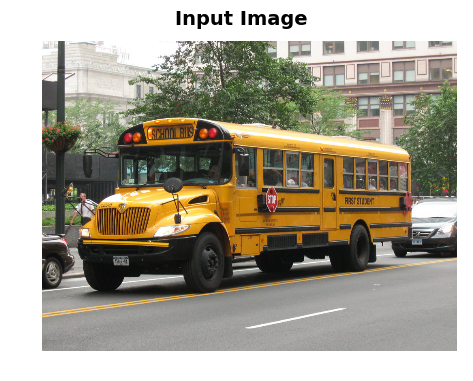

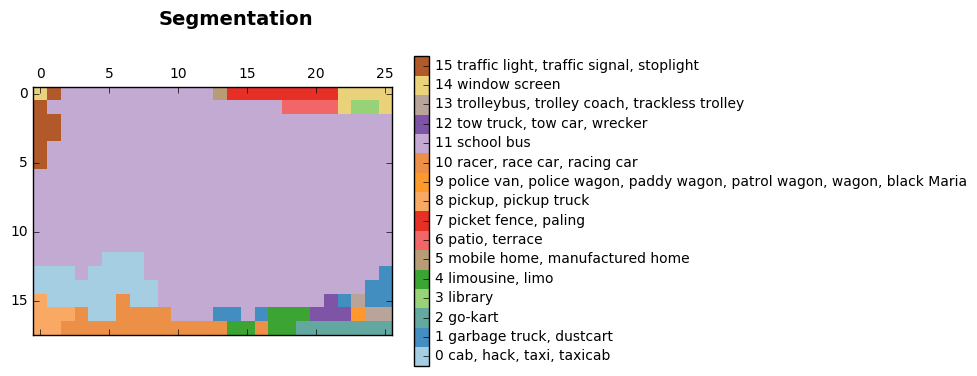

In [5]:
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

# Function to nicely print segmentation results with
# colorbar showing class names
def discrete_matshow(data, labels_names=[], title=""):
    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,
                      cmap=cmap,
                      vmin = np.min(data)-.5,
                      vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat,
                       ticks=np.arange(np.min(data),np.max(data)+1))
    
    # The names to be printed aside the colorbar
    if labels_names:
        cax.ax.set_yticklabels(labels_names)
    
    if title:
        plt.suptitle(title, fontsize=14, fontweight='bold')


with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    image_string = urllib2.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Convert image to float32 before subtracting the
    # mean pixel value
    image_float = tf.to_float(image, name='ToFloat')
    
    # Subtract the mean pixel value from each pixel
    processed_image = _mean_image_subtraction(image_float,
                                              [_R_MEAN, _G_MEAN, _B_MEAN])

    input_image = tf.expand_dims(processed_image, 0)
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        
        # spatial_squeeze option enables to use network in a fully
        # convolutional manner
        logits, _ = vgg.vgg_16(input_image,
                               num_classes=1000,
                               is_training=False,
                               spatial_squeeze=False)
    
    # For each pixel we get predictions for each class
    # out of 1000. We need to pick the one with the highest
    # probability. To be more precise, these are not probabilities,
    # because we didn't apply softmax. But if we pick a class
    # with the highest value it will be equivalent to picking
    # the highest value after applying softmax
    pred = tf.argmax(logits, dimension=3)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        segmentation, np_image = sess.run([pred, image])

# Remove the first empty dimension
segmentation = np.squeeze(segmentation)

# Let's get unique predicted classes (from 0 to 1000) and
# relable the original predictions so that classes are
# numerated starting from zero
unique_classes, relabeled_image = np.unique(segmentation,
                                            return_inverse=True)

segmentation_size = segmentation.shape

relabeled_image = relabeled_image.reshape(segmentation_size)

labels_names = []

for index, current_class_number in enumerate(unique_classes):

    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")